/tmp/ipykernel_1802057/1609535463.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)


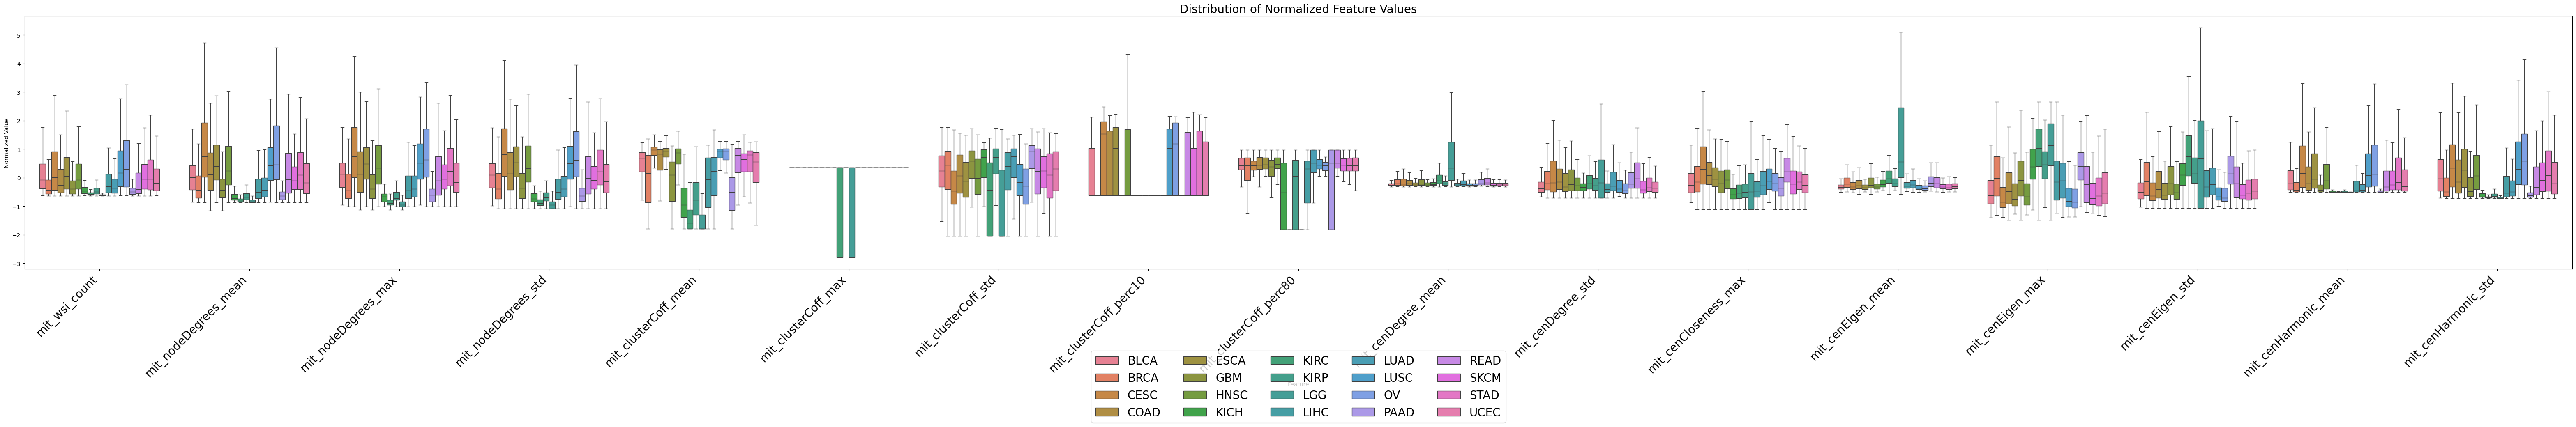

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()

df = discov_df [['type'] + feats_list]
df = discov_df[['type']+feats_list]
invalid_cancers = ['PCPG','DLBC','THYM','LAML','SARC','CHOL','ACC']
df = df[~df['type'].isin(invalid_cancers)]


# Step 1: Normalize features
normalized_df=(df[feats_list]-df[feats_list].mean())/df[feats_list].std()

normalized_df.insert(0, 'type', df['type'])

melted_df = pd.melt(normalized_df, id_vars='type', var_name='Feature', value_name='Normalized Value')

plt.figure(figsize=(80, 8))
boxplot = sns.boxplot(x='Feature', y='Normalized Value', hue='type', data=melted_df, showfliers=False)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
boxplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5, fontsize=20)
plt.title('Distribution of Normalized Feature Values', fontsize=20)

plt.savefig(f"mosi.png", bbox_inches='tight', dpi=600)


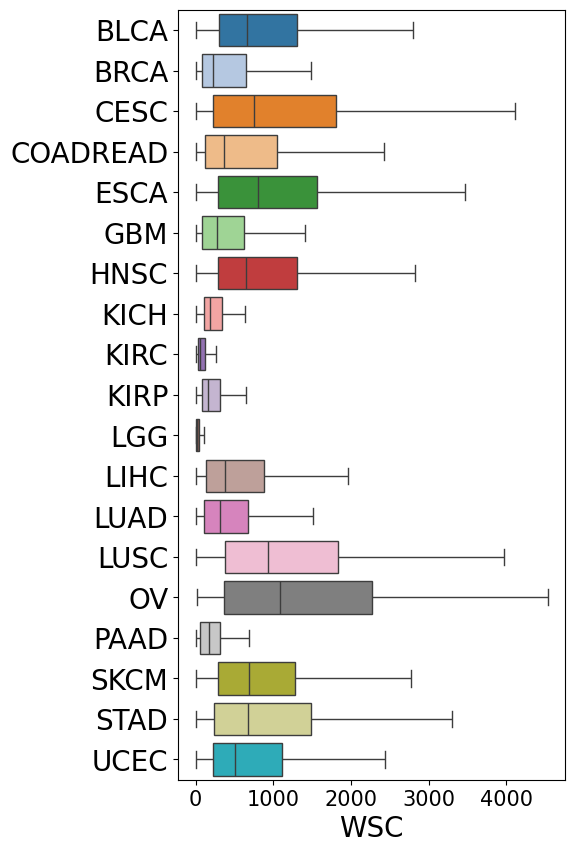

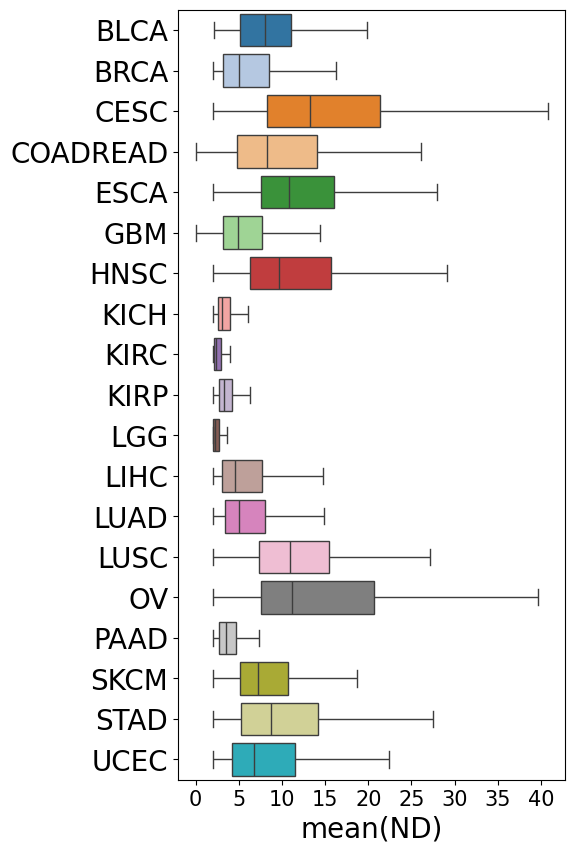

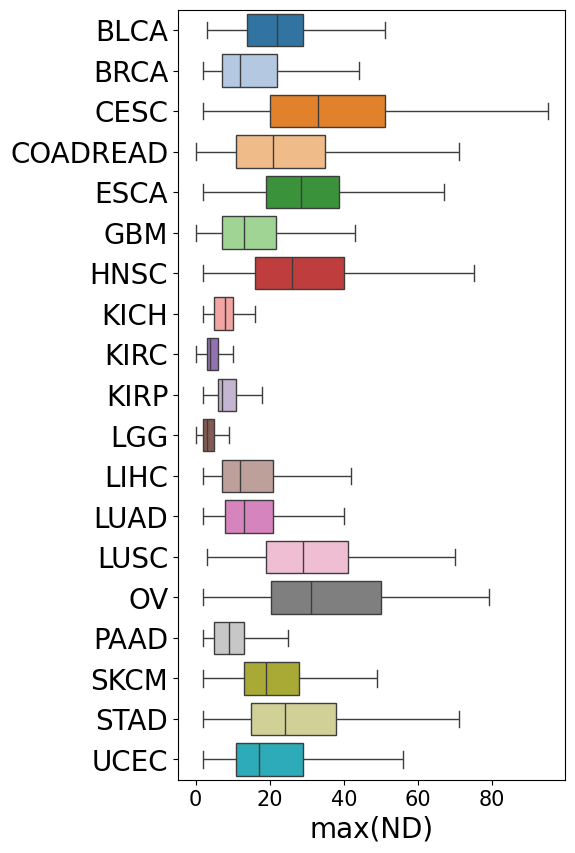

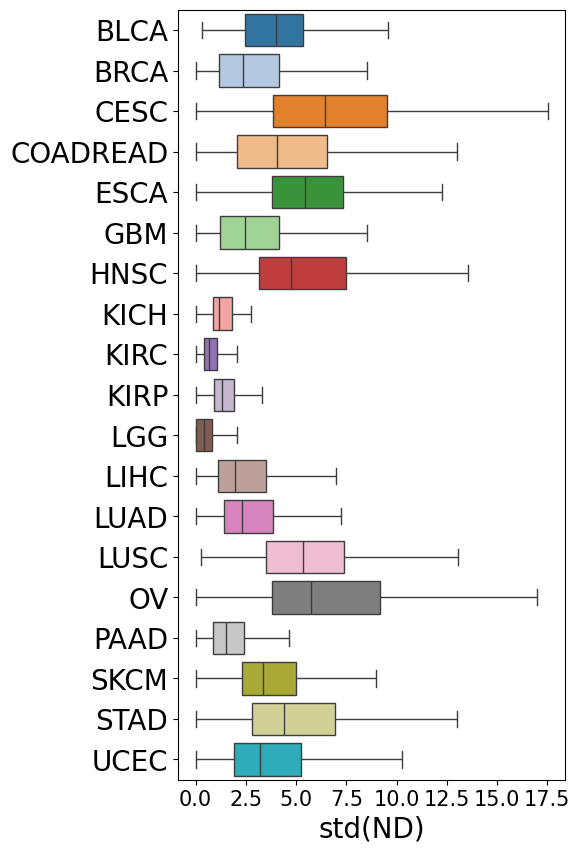

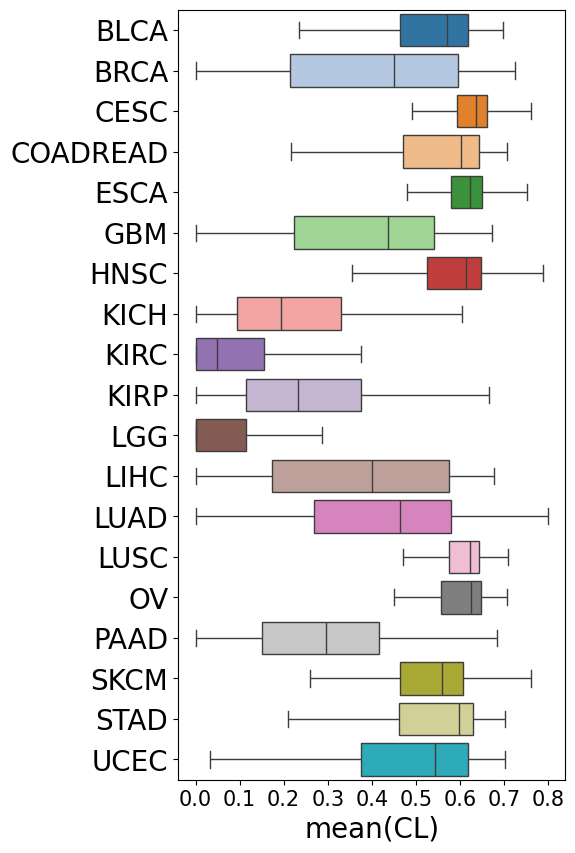

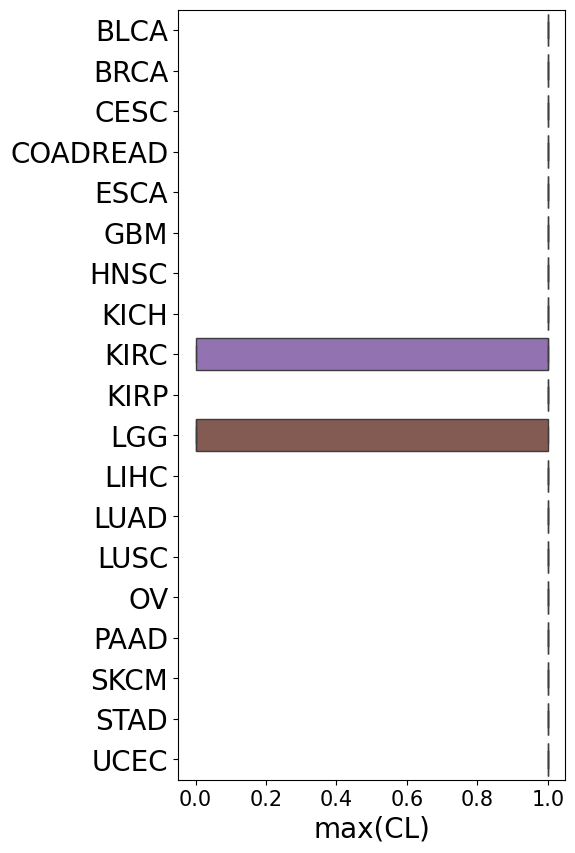

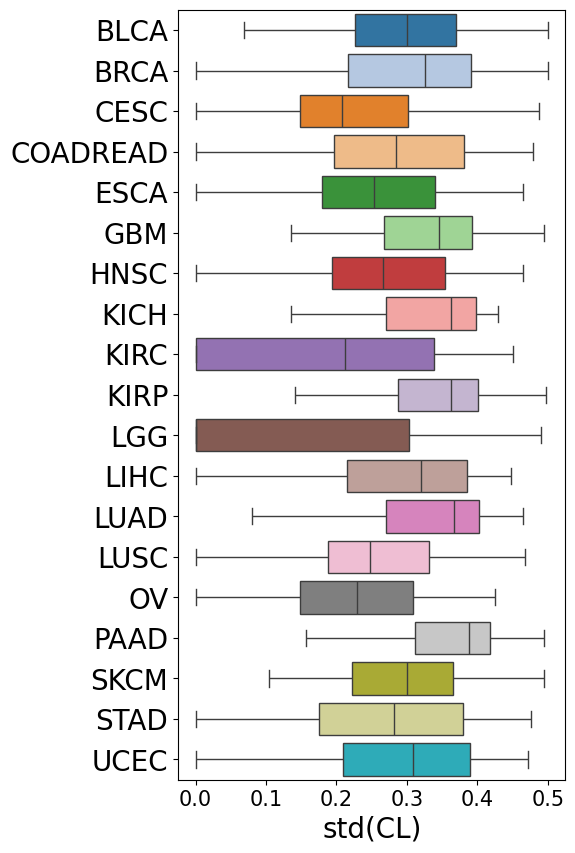

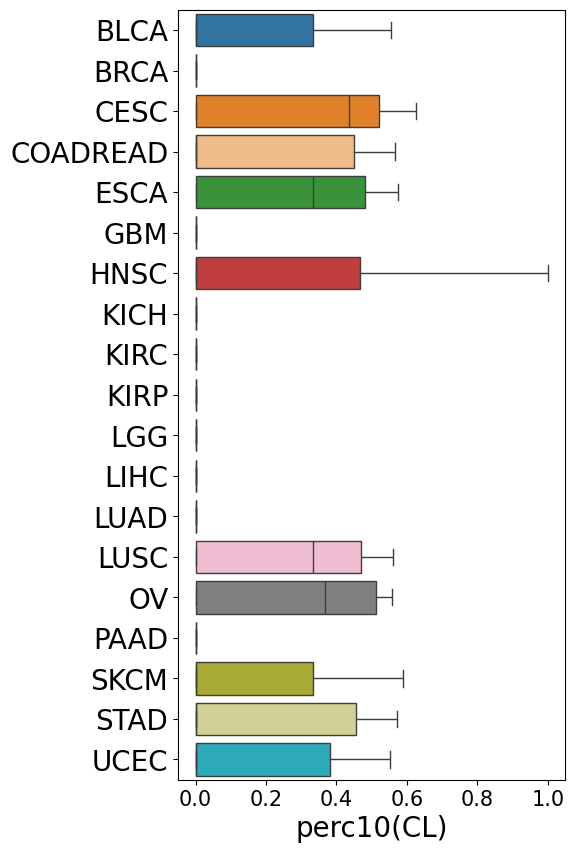

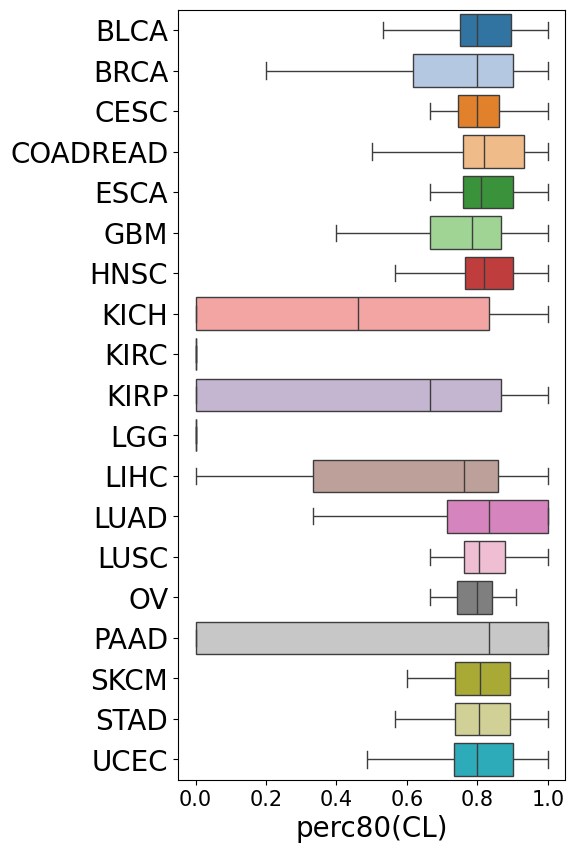

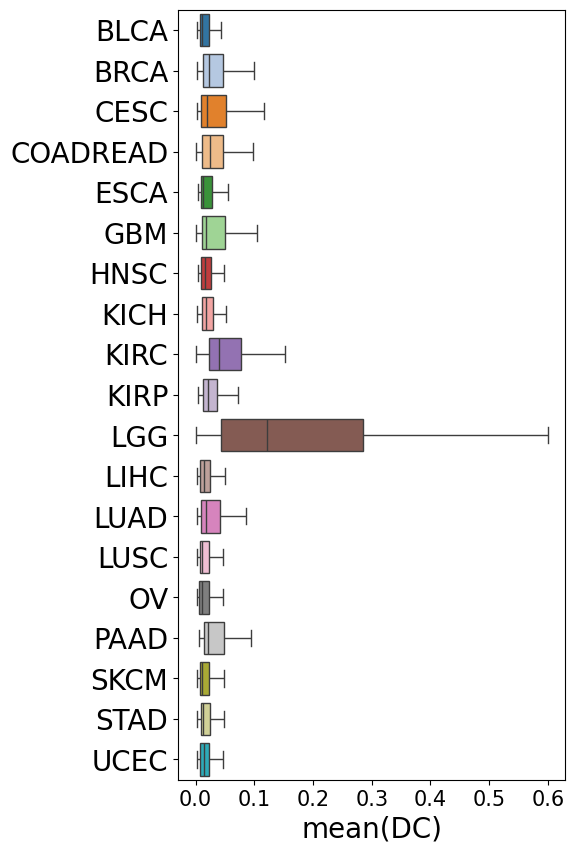

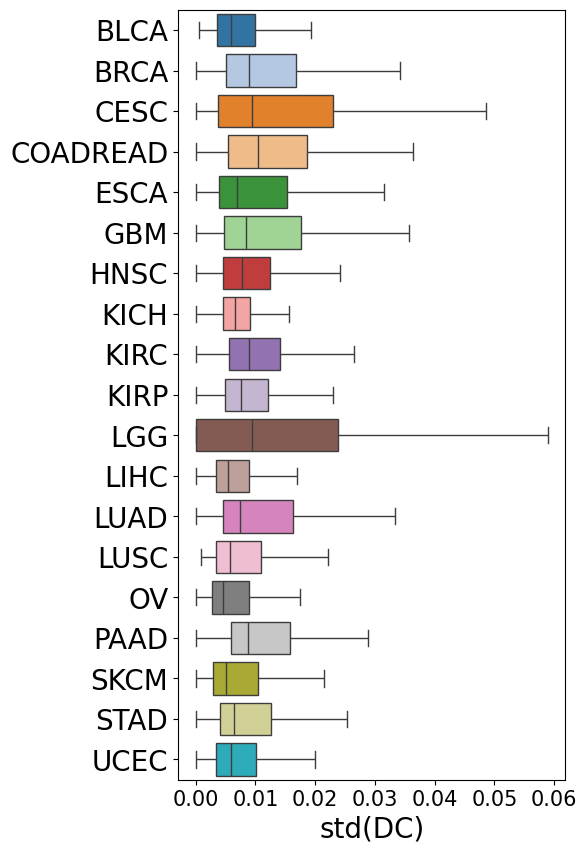

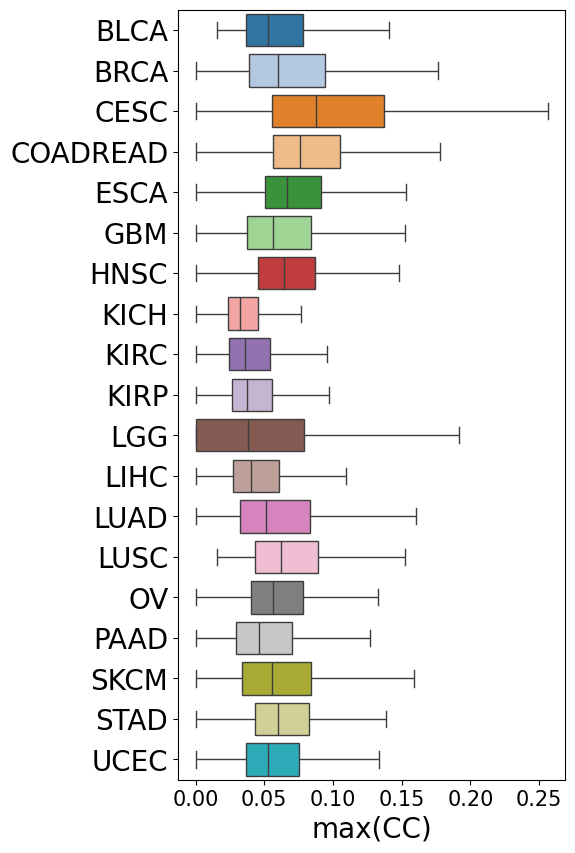

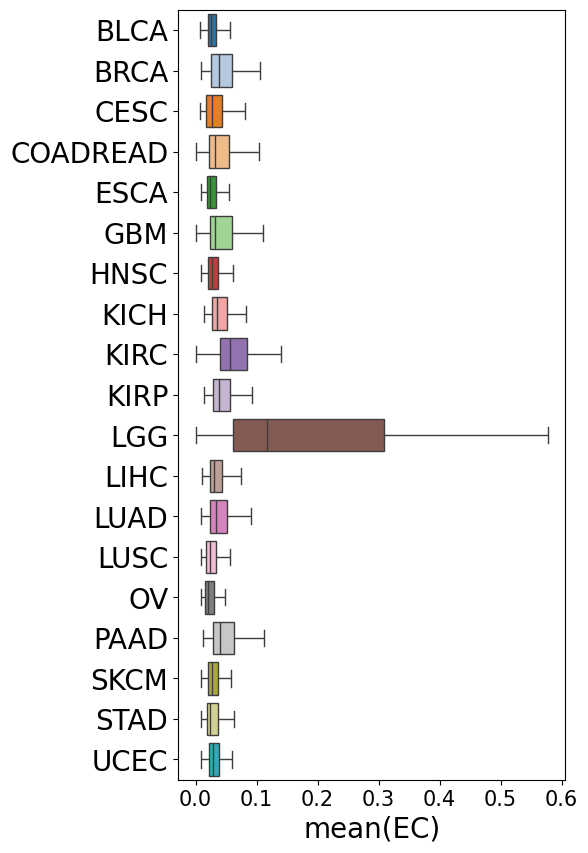

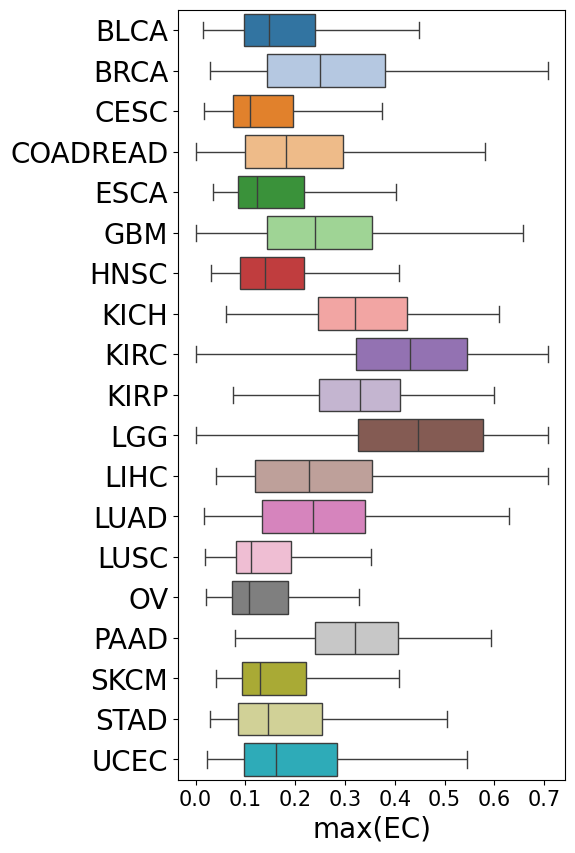

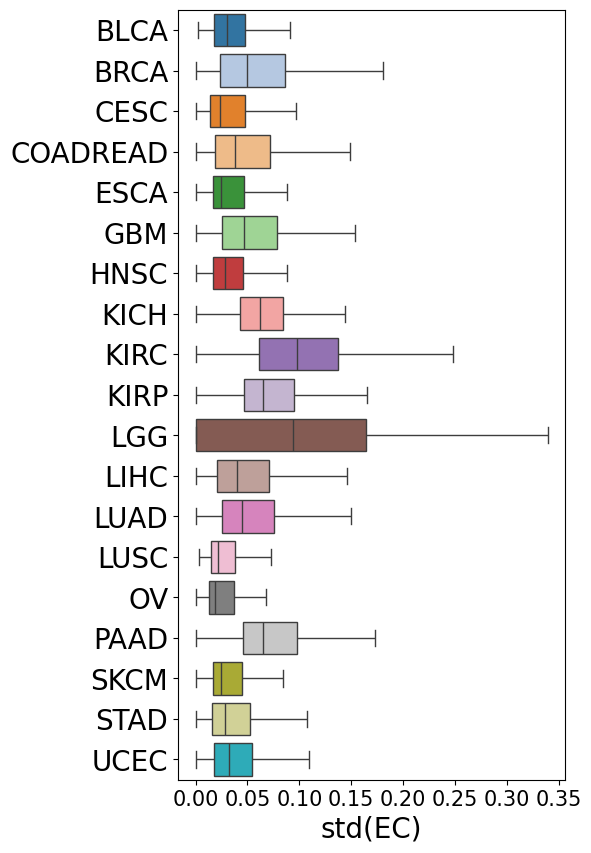

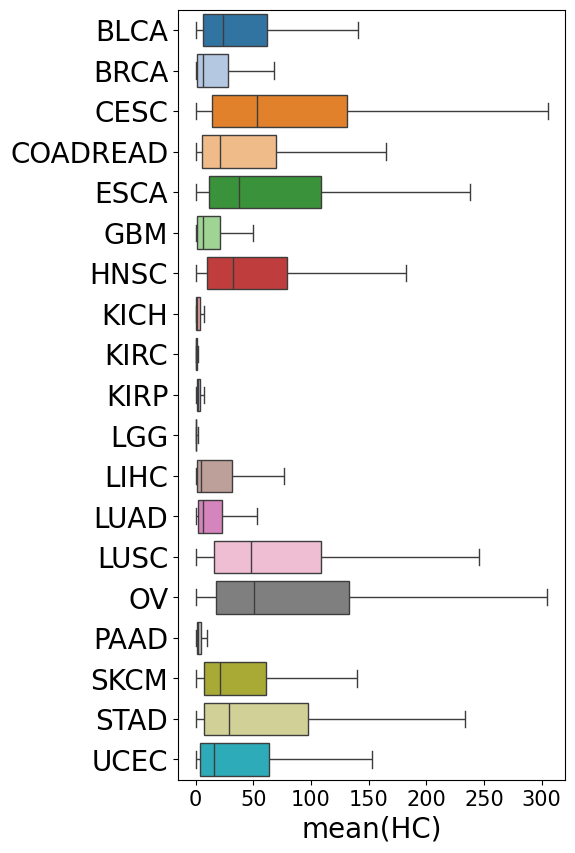

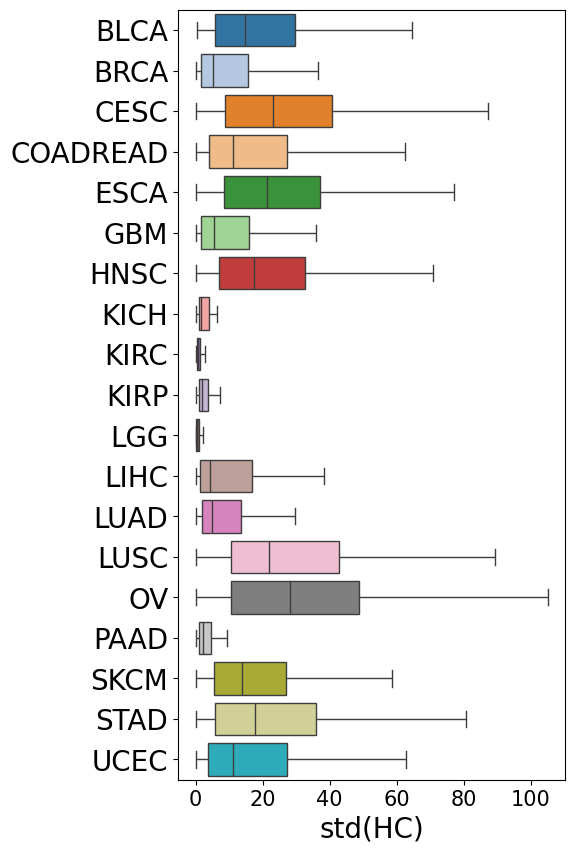

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_colors_dict, featre_to_tick

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()

df = discov_df [['type'] + feats_list]
df = discov_df[['type']+feats_list]
invalid_cancers = ['DLBC','THYM','LAML','SARC','CHOL','ACC']
df = df[~df['type'].isin(invalid_cancers)]

# change COAD and READ to COADREAD
df['type'] = df['type'].replace('COAD', 'COADREAD')
df['type'] = df['type'].replace('READ', 'COADREAD')

color_pallete = get_colors_dict()
for feat in feats_list:
    plt.figure(figsize=(5, 10))
    boxplot = sns.boxplot(y='type', x=feat, hue='type', data=df, showfliers=False, palette=color_pallete)
    # boxplot.set_yticklabels(boxplot.get_yticklabels(), horizontalalignment='right', fontsize=20)
    boxplot.set_xlabel(featre_to_tick(feat), fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=15)
    boxplot.set_ylabel('')
    plt.show()


/tmp/ipykernel_2034422/3903213608.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


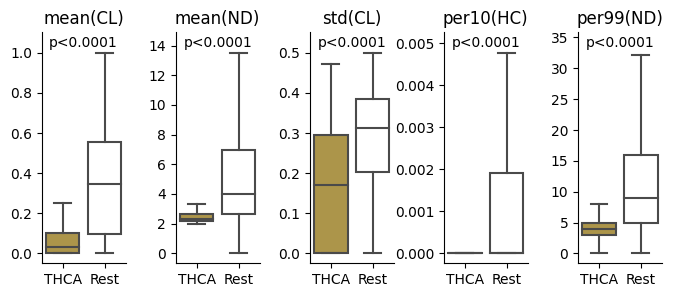

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from utils import get_colors_dict, featre_to_tick

# Loading the data
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer.csv'
discov_df = pd.read_csv(discov_val_feats_path)

desired_cancer_type = "THCA"
desired_features = [
                    "mit_clusterCoff_mean",
                    "mit_nodeDegrees_mean",
                    "mit_clusterCoff_std",
                    "mit_cenHarmonic_per10",
                    "mit_nodeDegrees_per99",
                    ]

# Filter and process the data
df = discov_df[['type'] + desired_features]
invalid_cancers = ['UVM', 'LAML']
df = df[~df['type'].isin(invalid_cancers)]

# Change COAD and READ to COADREAD
df['type'] = df['type'].replace(['COAD', 'READ'], 'COADREAD')
df['type'] = df['type'].replace(['GBM', 'LGG'], 'COADREAD')

# Get the color dictionary
color_dict = get_colors_dict()

# Set the palette based on the category
palette = {
    desired_cancer_type: color_dict.get(desired_cancer_type, 'blue'),
    "Rest": color_dict.get("Rest", 'white')
}

# Create a figure with subplots
# fig, axes = plt.subplots(1, len(desired_features), figsize=(1.5 * len(desired_features), 3.5))
fig, axes = plt.subplots(1, len(desired_features), figsize=(1.6 * len(desired_features), 3), gridspec_kw={'wspace': 0.6})

for ax, feature in zip(axes, desired_features):
    # Prepare the data for plotting
    plot_data = []
    
    # Data for the desired cancer type
    desired_data = df[df['type'] == desired_cancer_type][feature]
    plot_data.extend([(desired_cancer_type, val) for val in desired_data])
    
    # Data for all Rest cancer types
    Rest_data = df[df['type'] != desired_cancer_type][feature]
    plot_data.extend([('Rest', val) for val in Rest_data])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Category', 'Value'])

    # Plotting without outlier dots
    sns.boxplot(x='Category', y='Value', data=plot_df, palette=palette, showfliers=False, ax=ax)

    # Perform statistical tests and annotate the plot
    desired_values = plot_df[plot_df['Category'] == desired_cancer_type]['Value']
    Rest_values = plot_df[plot_df['Category'] == 'Rest']['Value']
    
    # Perform Mann-Whitney U test
    p_value = mannwhitneyu(desired_values, Rest_values, alternative='two-sided').pvalue
    
    # Calculate position for text annotation
    Q1_desired = desired_values.quantile(0.25)
    Q3_desired = desired_values.quantile(0.75)
    IQR_desired = Q3_desired - Q1_desired
    max_whisker_desired = min(max(desired_values), Q3_desired + 1.5 * IQR_desired)

    Q1_Rest = Rest_values.quantile(0.25)
    Q3_Rest = Rest_values.quantile(0.75)
    IQR_Rest = Q3_Rest - Q1_Rest
    max_whisker_Rest = min(max(Rest_values), Q3_Rest + 1.5 * IQR_Rest)

    max_whisker = max(max_whisker_desired, max_whisker_Rest) * 1.05
    text_y = max_whisker# + 0.05 * max_whisker
    
    # Add annotation with white background
    if p_value > 0.0001:
        t = ax.text(0.5, text_y, f"p={p_value:.3f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
        t.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor=None))
    else:
        t= ax.text(0.5, text_y, f"p<0.0001", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
        t.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Draw line for significance
    # ax.plot([0, 1], [max_whisker] * 2, color='black', lw=1.5, marker='|')

    # Set the title of the subplot
    ax.set_title(f'{featre_to_tick(feature)}')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim([None, max_whisker*1.05])

    # Remove top and right box lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

save_dir = "results_final/landscape/domain_classification_one-vs-rest/"
plt.tight_layout()
plt.savefig(save_dir+f"top_feat_dist_{desired_cancer_type}.png", dpi=600, bbox_inches='tight')
# plt.show()
